# Burrau example using Complex Numbers (Github)

## Loading packages

In [1]:
using IRKGaussLegendre
using Plots, LinearAlgebra, LaTeXStrings


## Step 1: Defining the Problem
To solve this numerically, we define a problem type by giving it the equation, the initial condition, and the timespan to solve over:

In [2]:
function NbodyODE_Complex!(du,u,Gm,t)
    
     N = length(Gm)
     du[1,:] .= zero(eltype(u))
     for i in 1:N
        qi = u[2,i]
        Gmi = Gm[i]
        du[2,i] = u[1,i]
        for j in (i+1):N
           qj = u[2,j]
           Gmj = Gm[j]
           qij = qi - qj
           auxij=abs(qij)^(-3)
           du[1,i] -= Gmj*auxij*qij
           du[1,j] += Gmi*auxij*qij
        end
     end

    return
    
end

NbodyODE_Complex! (generic function with 1 method)

In [3]:
u0=[1.0+0.0im,0.0+0.0im];

Gm = [5, 4, 3]
N=length(Gm)
q0=[1.0+-1.0im, -2.0+-1.0im,1.0+3.0im]
v0=zero(q0)
u0 = Array{ComplexF64}(undef,2,N)
u0[1,:]=v0
u0[2,:]=q0
tspan = (0.0,63.0)
prob=ODEProblem(NbodyODE_Complex!,u0,tspan,Gm);

## Step 2: Solving the problem
After defining a problem, you solve it using solve

In [4]:
sol1=solve(prob,IRKGL16(),adaptive=true, reltol=1e-12, abstol=1e-12);

### Orbits

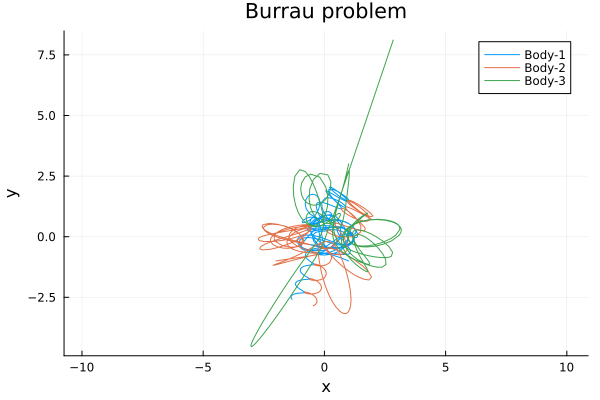

In [5]:
bodylist = ["Body-1", "Body-2", "Body-3"]
pl = plot(title="Burrau problem",xlabel="x", ylabel="y",aspect_ratio=1)

ulist1 = sol1.u[1:end]
tlist1 = sol1.t[1:end]

for j = 1:3
 xlist  = map(u->real(u[2,j]), ulist1)
 ylist  = map(u->imag(u[2,j]), ulist1)
 pl = plot!(xlist,ylist, label = bodylist[j])   
end  
plot(pl)

### Step size

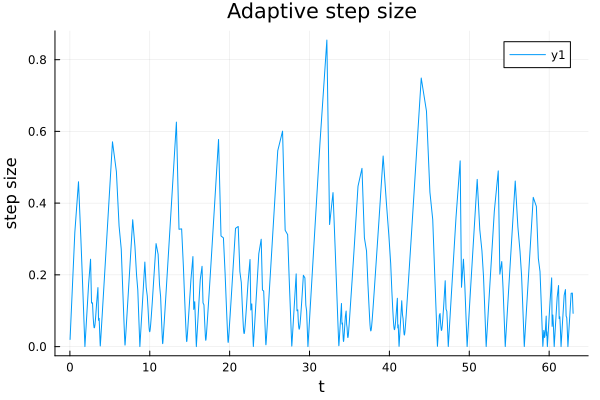

In [6]:
plot(xlabel="t", ylabel="step size",title="Adaptive step size")
steps1 =sol1.t[2:end]-sol1.t[1:end-1]
plot!(sol1.t[2:end],steps1)

### Energy-Error

In [7]:
function NbodyEnergy_Complex(u,Gm)
    
     N = length(Gm)
     zerouel = zero(eltype(u))
     T = real(zerouel)
     U = real(zerouel)
     for i in 1:N
        qi = u[2,i]
        vi = u[1,i]
        Gmi = Gm[i]
        T += Gmi*(vi*conj(vi))
        for j in (i+1):N
           qj = u[2,j]  
           Gmj = Gm[j]
           qij = qi - qj
           U -= Gmi*Gmj/norm(qij)
        end
     end
    1/2*T + U
end

NbodyEnergy_Complex (generic function with 1 method)

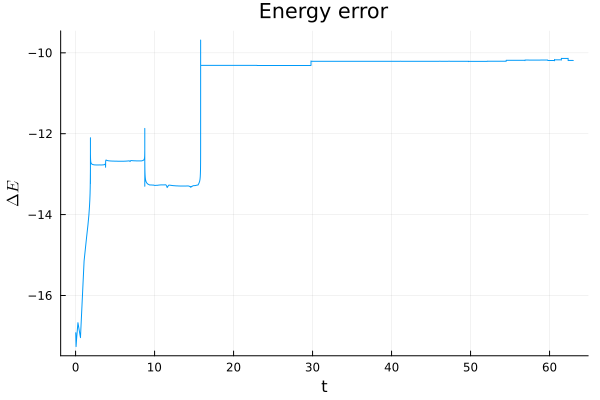

In [8]:
setprecision(BigFloat, 256)
u0Big=convert.(Complex{BigFloat},u0)
GmBig=BigFloat.(Gm)

E0=NbodyEnergy_Complex(u0Big,GmBig)
ΔE1 = map(x->NbodyEnergy_Complex(convert.(Complex{BigFloat},x),GmBig), sol1.u)./E0.-1
plot(title="Energy error", xlabel="t", ylabel=L"\Delta E")
plot!(sol1.t,log10.(abs.(ΔE1)), label="")